# RNN Tron Challenge - Interactive Notebook

This notebook loads your agent from `student_template.py` and provides visualizations.

## Step 1: Import Dependencies

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Add student_package to path
sys.path.append('.')

%matplotlib inline

## Step 2: Import Your Agent from Template

Load your STUDENT_INFO, MyModel, and StudentAgent from the template file.

In [2]:
# Import your agent components from student_template.py
from student_template import STUDENT_INFO, MyModel, StudentAgent

# Display student information
print("=== Your Submission Info ===")
for key, value in STUDENT_INFO.items():
    print(f"{key}: {value}")

=== Your Submission Info ===
name: AI Assistant
student_id: 12345678
team_name: TronWinner
description: LSTM Agent with 128 hidden units


## Step 3: Train Your Model

In [6]:
def train_model(data_path="train_X.npy", labels_path="train_Y.npy", 
                epochs=50, lr=0.001, batch_size=32):
    """Train your model"""
    print("Loading data...")
    X = np.load(data_path)
    Y = np.load(labels_path)
    print(f"Loaded {len(X)} samples")
    
    agent = StudentAgent()
    param_count = sum(p.numel() for p in agent.parameters())
    print(f"\nModel has {param_count:,} parameters (max allowed: 100,000)")
    
    if param_count > 100000:
        print("WARNING: Model exceeds parameter limit!")
    
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X), torch.LongTensor(Y)
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(agent.parameters(), lr=lr)
    
    print("\nStarting training...")
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            out = agent.model(batch_x)
            if isinstance(out, tuple):
                out = out[0]
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (torch.argmax(out, dim=1) == batch_y).sum().item()
        
        acc = 100 * correct / len(X)
        print(f"Epoch {epoch+1}/{epochs}: Loss={total_loss/len(loader):.4f}, Acc={acc:.2f}%")
    
    # Save model
    os.makedirs("submissions", exist_ok=True)
    save_path = f"submissions/{STUDENT_INFO['name'].replace(' ', '_').lower()}_agent.pth"
    torch.save(agent.state_dict(), save_path)
    print(f"\n✓ Saved to {save_path}")
    return agent

# Set training parameters
epochs = 50      # Try 10, 20, 50...
lr = 0.001       # Try 0.001, 0.0005, 0.0001...
batch_size = 32  # Try 16, 32, 64...

# Train the model
agent = train_model(epochs=epochs, lr=lr, batch_size=batch_size)

Loading data...
Loaded 22084 samples

Model has 87,364 parameters (max allowed: 100,000)

Starting training...
Epoch 1/50: Loss=1.2288, Acc=42.49%
Epoch 2/50: Loss=1.1500, Acc=44.97%
Epoch 3/50: Loss=1.0913, Acc=46.12%
Epoch 4/50: Loss=1.0463, Acc=46.97%
Epoch 5/50: Loss=1.0097, Acc=48.39%
Epoch 6/50: Loss=0.9807, Acc=49.39%
Epoch 7/50: Loss=0.9571, Acc=50.39%
Epoch 8/50: Loss=0.9373, Acc=51.44%
Epoch 9/50: Loss=0.9192, Acc=51.95%
Epoch 10/50: Loss=0.8974, Acc=53.34%
Epoch 11/50: Loss=0.8828, Acc=54.68%
Epoch 12/50: Loss=0.8650, Acc=55.83%
Epoch 13/50: Loss=0.8465, Acc=56.79%
Epoch 14/50: Loss=0.8284, Acc=58.37%
Epoch 15/50: Loss=0.8085, Acc=60.08%
Epoch 16/50: Loss=0.7889, Acc=61.32%
Epoch 17/50: Loss=0.7688, Acc=62.99%
Epoch 18/50: Loss=0.7490, Acc=63.76%
Epoch 19/50: Loss=0.7288, Acc=65.33%
Epoch 20/50: Loss=0.7049, Acc=66.95%
Epoch 21/50: Loss=0.6893, Acc=67.90%
Epoch 22/50: Loss=0.6644, Acc=69.69%
Epoch 23/50: Loss=0.6429, Acc=70.80%
Epoch 24/50: Loss=0.6222, Acc=72.38%
Epoch 25/5

## Step 4: Visualize Your Agent Playing

Watch your trained agent play against a random opponent.

In [47]:
# Constants (same as tron_env.py)
GRID_SIZE = 20
FPS = 10

EMPTY = 0
P1_HEAD = 2
P1_TRAIL = 3
P2_HEAD = 4
P2_TRAIL = 5

# Colors (same as tron_env.py)
BLUE = (50, 50, 255)
RED = (255, 50, 50)
DARK_BLUE = (0, 0, 150)
DARK_RED = (150, 0, 0)

def get_lidar_observation(pos, grid):
    """Generate lidar observation (same as tron_env.py)"""
    obs = np.zeros(10, dtype=np.float32)
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    
    for i, (dr, dc) in enumerate(directions):
        dist = 0
        r, c = pos
        while True:
            r += dr
            c += dc
            dist += 1
            if r < 0 or r >= GRID_SIZE or c < 0 or c >= GRID_SIZE or grid[r, c] != EMPTY:
                break
        obs[i] = min(dist, GRID_SIZE) / GRID_SIZE
    
    obs[8] = pos[0] / GRID_SIZE
    obs[9] = pos[1] / GRID_SIZE
    return obs

def simulate_game(agent1, agent2=None, max_steps=200):
    """Simulate a game and return the history"""
    grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    
    # Random spawn points
    while True:
        p1_r, p1_c = random.randint(2, GRID_SIZE-3), random.randint(2, GRID_SIZE-3)
        p2_r, p2_c = random.randint(2, GRID_SIZE-3), random.randint(2, GRID_SIZE-3)
        if abs(p1_r - p2_r) + abs(p1_c - p2_c) > GRID_SIZE / 2:
            break
    
    p1_pos = [p1_r, p1_c]
    p2_pos = [p2_r, p2_c]
    grid[p1_r, p1_c] = P1_HEAD
    grid[p2_r, p2_c] = P2_HEAD
    
    agent1.reset()
    if agent2:
        agent2.reset()
    
    p1_dir = -1
    p2_dir = -1
    grid_history = [grid.copy()]
    moves = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
    
    for step in range(max_steps):
        # Get observations
        obs1 = get_lidar_observation(p1_pos, grid)
        obs2 = get_lidar_observation(p2_pos, grid)
        
        # Get actions
        action1 = agent1.get_action(obs1)
        action2 = agent2.get_action(obs2) if agent2 else random.randint(0, 3)
        
        # Handle invalid 180-degree turns
        if p1_dir == 0 and action1 == 1: action1 = 0
        if p1_dir == 1 and action1 == 0: action1 = 1
        if p1_dir == 2 and action1 == 3: action1 = 2
        if p1_dir == 3 and action1 == 2: action1 = 3
        
        p1_dir = action1
        p2_dir = action2
        
        # Calculate new positions
        dr, dc = moves[action1]
        new_p1 = [p1_pos[0] + dr, p1_pos[1] + dc]
        dr, dc = moves[action2]
        new_p2 = [p2_pos[0] + dr, p2_pos[1] + dc]
        
        # Check collisions
        p1_crashed = (new_p1[0] < 0 or new_p1[0] >= GRID_SIZE or 
                     new_p1[1] < 0 or new_p1[1] >= GRID_SIZE or 
                     grid[new_p1[0], new_p1[1]] != EMPTY)
        p2_crashed = (new_p2[0] < 0 or new_p2[0] >= GRID_SIZE or 
                     new_p2[1] < 0 or new_p2[1] >= GRID_SIZE or 
                     grid[new_p2[0], new_p2[1]] != EMPTY)
        
        if p1_crashed or p2_crashed or new_p1 == new_p2:
            break
        
        # Update grid
        grid[p1_pos[0], p1_pos[1]] = P1_TRAIL
        grid[p2_pos[0], p2_pos[1]] = P2_TRAIL
        p1_pos = new_p1
        p2_pos = new_p2
        grid[p1_pos[0], p1_pos[1]] = P1_HEAD
        grid[p2_pos[0], p2_pos[1]] = P2_HEAD
        
        grid_history.append(grid.copy())
    
    return grid_history, p1_crashed, p2_crashed

# Run simulation
print("Simulating game...")
grid_history, p1_crashed, p2_crashed = simulate_game(agent, max_steps=200)
print(f"Game lasted {len(grid_history)-1} steps")
if p1_crashed and p2_crashed:
    print("Result: Draw (both crashed)")
elif p1_crashed:
    print("Result: Loss (you crashed)")
elif p2_crashed:
    print("Result: Win (opponent crashed)")
else:
    print("Result: Draw (max steps reached)")

Simulating game...
Game lasted 8 steps
Result: Win (opponent crashed)


## Step 5: Watch the Animation

In [48]:
# Create animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('black')

def draw_grid(frame):
    ax.clear()
    ax.set_facecolor('black')
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(GRID_SIZE, 0)
    ax.set_aspect('equal')
    ax.axis('off')
    
    current_grid = grid_history[frame]
    
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            cell_val = current_grid[r, c]
            if cell_val == P1_HEAD:
                color = np.array(BLUE) / 255.0
            elif cell_val == P1_TRAIL:
                color = np.array(DARK_BLUE) / 255.0
            elif cell_val == P2_HEAD:
                color = np.array(RED) / 255.0
            elif cell_val == P2_TRAIL:
                color = np.array(DARK_RED) / 255.0
            else:
                continue
            
            rect = plt.Rectangle((c, r), 1, 1, facecolor=color, edgecolor='none')
            ax.add_patch(rect)
    
    ax.set_title(f'Step {frame}/{len(grid_history)-1}', color='white', fontsize=12)

anim = FuncAnimation(fig, draw_grid, frames=len(grid_history), 
                    interval=1000//FPS, blit=False)

# Display animation
display(HTML(anim.to_jshtml()))
plt.close()

## Step 6: View Final State

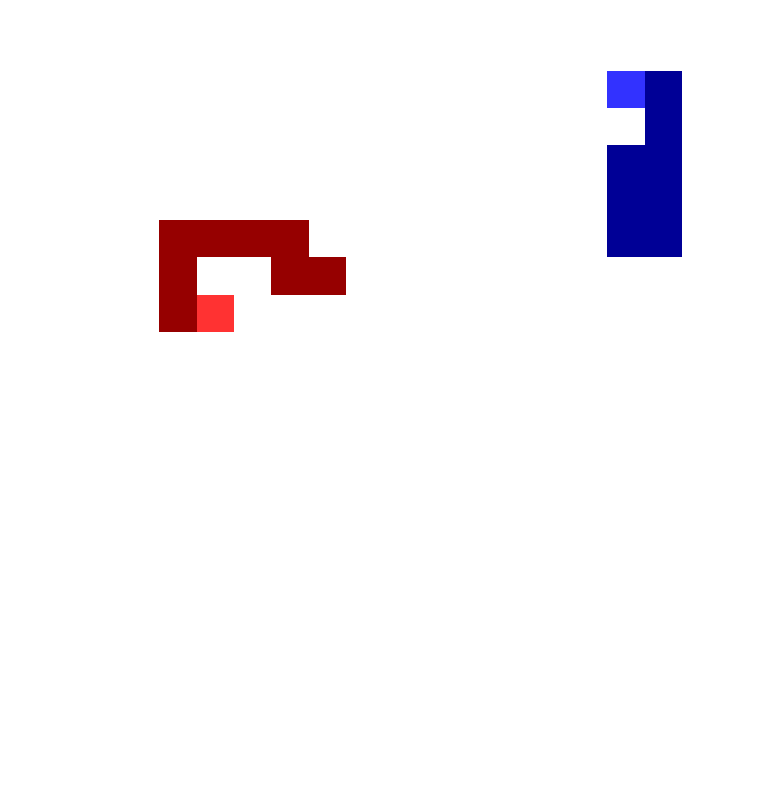

In [49]:
# Display final game state
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('black')
ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(GRID_SIZE, 0)
ax.set_aspect('equal')
ax.axis('off')

final_grid = grid_history[-1]

for r in range(GRID_SIZE):
    for c in range(GRID_SIZE):
        cell_val = final_grid[r, c]
        if cell_val == P1_HEAD:
            color = np.array(BLUE) / 255.0
        elif cell_val == P1_TRAIL:
            color = np.array(DARK_BLUE) / 255.0
        elif cell_val == P2_HEAD:
            color = np.array(RED) / 255.0
        elif cell_val == P2_TRAIL:
            color = np.array(DARK_RED) / 255.0
        else:
            continue
        
        rect = plt.Rectangle((c, r), 1, 1, facecolor=color, edgecolor='none')
        ax.add_patch(rect)

ax.set_title(f'Final State - Step {len(grid_history)-1}', color='white', fontsize=14)
plt.tight_layout()
plt.show()